<h1><center>Поиск аномалий в транзакциях</center></h1>

**Подключение необходимых библиотек и загрузка данных**

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from umap import UMAP
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm
from time import time

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option("display.max_columns", None)

In [2]:
data = pd.read_csv("data/creditcard.csv")
data.shape

(284807, 31)

<h2>EDA</h2>

Данные представляют из себя первые 28 главных компонент, полученных после PCA преобразования оригинальных данных 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Пропусков нет, все данные представлены в числовой шкале.

Посмотрим на основные характеристики переменных (без столбца с экспертной оценкой)

In [4]:
features = data.drop(columns="Class")
features.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,1.772925e-15,9.289524e-16,-1.803266e-15,1.674888e-15,1.475621e-15,3.501098e-15,1.392460e-15,-7.466538e-16,4.258754e-16,9.019919e-16,5.126845e-16,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


**Построим эмпирические оценки плотности распределения каждого признака в разрезе атрибута** ***Class***

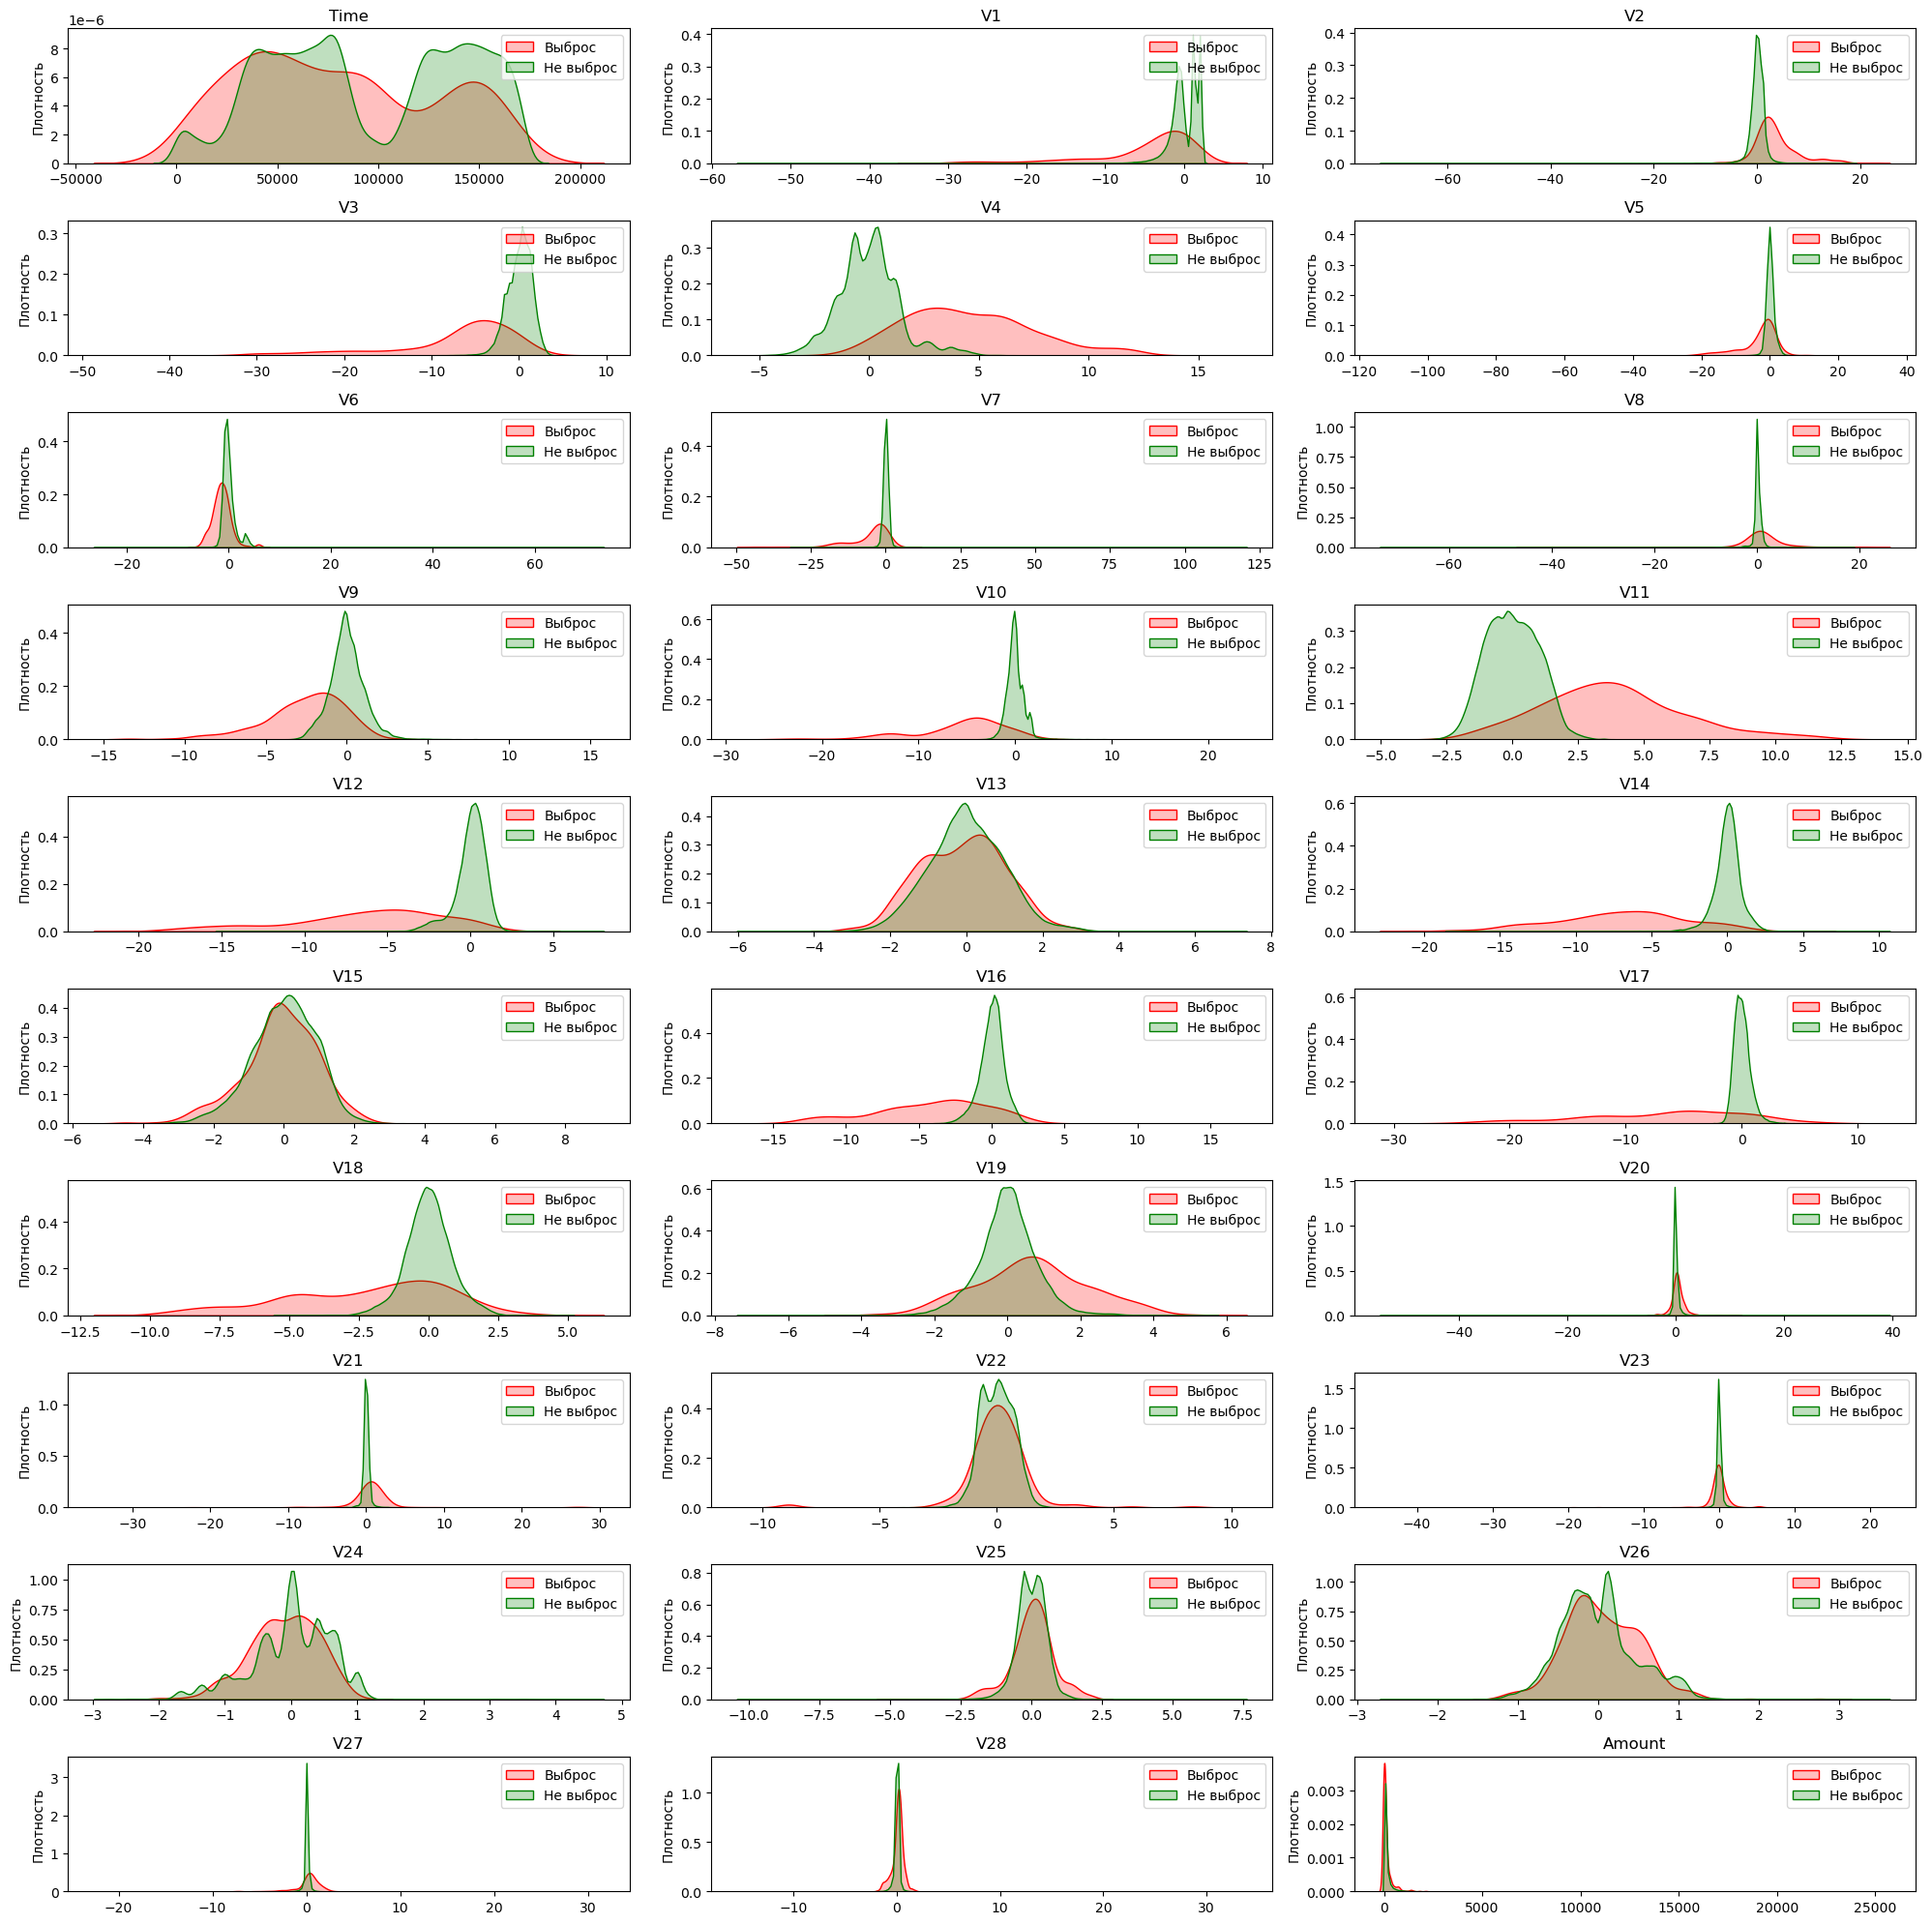

In [5]:
n_cols = 3  
n_rows = (len(features.columns) + n_cols - 1) // n_cols  

plt.figure(figsize=(20, 10*2))  

for n, col in enumerate(features.columns, 1):
    plt.subplot(n_rows, n_cols, n)  
    sns.kdeplot(data[data['Class'] == 1][col], color='r', label='Выброс', fill=True)
    sns.kdeplot(data[data['Class'] == 0][col], color='g', label='Не выброс', fill=True)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('Плотность')
    plt.legend()


plt.tight_layout()
plt.show()

Удалим неинформативные переменные

In [6]:
features.drop(columns=["V13", "V15", "V22", "V24", "V25", "V26", "V28", "Amount"], inplace=True)
data.drop(columns=["V13", "V15", "V22", "V24", "V25", "V26", "V28", "Amount"], inplace=True)

**Вычислим экспертную оценку загрязненности датасета**

In [7]:
expert_assessment = data.loc[data['Class'] == 1, :].shape[0] / data.shape[0]

print(data["Class"].value_counts())
print(f"Доля мошеннических транзакций: {np.round(100 * expert_assessment,  3)}%")

0    284315
1       492
Name: Class, dtype: int64
Доля мошеннических транзакций: 0.173%


<h2>Применение различных методов для обнаружения выбросов</h2>

Перед обучением моделей произведем трансформацию данных, а именно робастное масштабирование, так как при обучении некоторых алгоритмов учитываются расстояния между объектами

In [8]:
scaler = RobustScaler()
data_scaled = scaler.fit_transform(features)

*Реализуем функции, которые будем применять в процессе обучения разных моделей*

In [9]:
def show_model_metrics(model_title: str, true: np.array, pred:  np.array): # функция для оценки качества модели
    print(" "*30, f"Оценка качества модели {model_title}", end="\n\n")
    print(" "*20, "Матрица ошибок")
    
    conf_matrix = confusion_matrix(true, pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap='Blues')
    plt.show()
    
    print("-"*60, end="\n\n")
    print(" "*3, f"Отчет по рассчитанным метрикам качества классификации")
    print(classification_report(true, pred))

In [10]:
def reduce_data(data, n_components=3): # функция для сжатия данных
    data_pre_reduced = data_scaled.copy()

    umap_obj = UMAP(n_components=n_components, verbose=1, n_jobs=-1, random_state=42)

    start_time = time()
    print("Начинается расчет UMAP...")
    data_reduced = umap_obj.fit_transform(data_pre_reduced)
    end_time = time()
    print(f"Время выполнения: {end_time - start_time:.2f} секунд")
    return data_reduced

In [11]:
def display_objects(data_reduced, true, pred):
    TP = (true == 1) & (pred == 1)  # Модель верно нашла выброс
    FP = (true == 0) & (pred == 1)  # Модель ошибочно пометила нормальные точки как выброс
    TN = (true == 0) & (pred == 0)  # Модель правильно пометила нормальные точки
    FN = (true == 1) & (pred == 0)  # Модель пропустила выброс

    if data_reduced.shape[1] == 2:
        plt.figure(figsize=(12, 10))

        plt.scatter(data_reduced[TN, 0], data_reduced[TN, 1], color="gray", alpha=0.2, 
                    s=15, label="TN (True Negative)")
        plt.scatter(data_reduced[TP, 0], data_reduced[TP, 1], color="red", alpha=0.8, 
                    s=15, label="TP (True Positive)")
        plt.scatter(data_reduced[FP, 0], data_reduced[FP, 1], color="green", alpha=0.4,
                    s=15, label="FP (False Positive)")
        plt.scatter(data_reduced[FN, 0], data_reduced[FN, 1], color="blue", alpha=0.6, 
                     s=15, label="FN (False Negative)")

        plt.title("UMAP проекция (2D) - TP/FP/TN/FN")
        plt.xlabel("Первая компонента")
        plt.ylabel("Вторая компонента")
        plt.legend()
        plt.show()
    
    elif data_reduced.shape[1] == 3:
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection="3d")

        ax.scatter(data_reduced[TN, 0], data_reduced[TN, 1], data_reduced[TN, 2], color="gray", s=15,
                   alpha=0.2, label="TN (True Negative)")
        ax.scatter(data_reduced[TP, 0], data_reduced[TP, 1], data_reduced[TP, 2], color="red", s=15, 
                   alpha=0.8, label="TP (True Positive)")
        ax.scatter(data_reduced[FP, 0], data_reduced[FP, 1], data_reduced[FP, 2], color="green", s=15, 
                   alpha=0.4, label="FP (False Positive)")
        ax.scatter(data_reduced[FN, 0], data_reduced[FN, 1], data_reduced[FN, 2], color="blue", s=15, 
                   alpha=0.6, label="FN (False Negative)")

        ax.set_title("UMAP проекция (3D) - TP/FP/TN/FN")
        ax.set_xlabel("Первая компонента")
        ax.set_ylabel("Вторая компонента")
        ax.set_zlabel("Третья компонента")
        plt.legend()
        plt.show()
    
    else:
        print("Только 2D и 3D визуализации поддерживаются.")

In [12]:
data_reduced = reduce_data(data_scaled, 2)

Начинается расчет UMAP...
UMAP(n_jobs=1, random_state=42, verbose=1)
Fri Jan 31 12:40:48 2025 Construct fuzzy simplicial set
Fri Jan 31 12:40:48 2025 Finding Nearest Neighbors
Fri Jan 31 12:40:48 2025 Building RP forest with 32 trees
Fri Jan 31 12:41:01 2025 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	Stopping threshold met -- exiting after 3 iterations
Fri Jan 31 12:41:32 2025 Finished Nearest Neighbor Search
Fri Jan 31 12:41:37 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jan 31 12:53:59 2025 Finished embedding
Время выполнения: 791.96 секунд


Отображение объектов, помеченных как **аномалии** экспертами, на компонентах, полученных с помощью UMAP

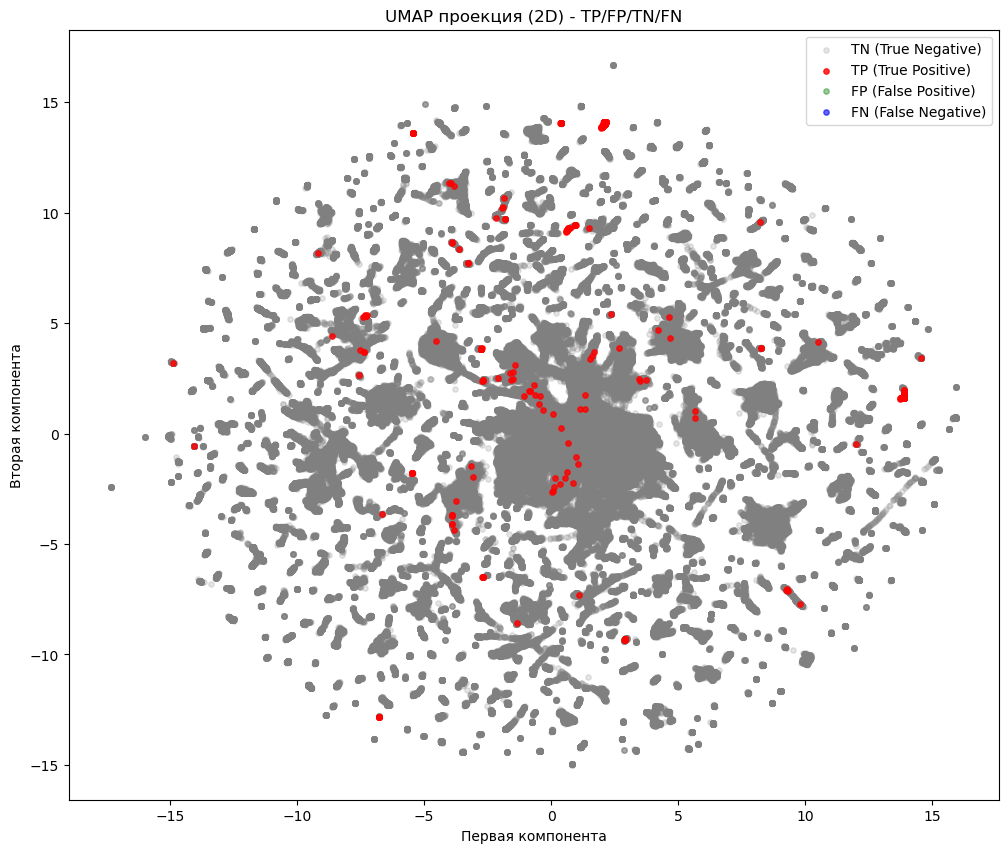

In [13]:
display_objects(data_reduced, data["Class"].values, data["Class"].values)

<h3>Статистический метод для обнаружения аномальных объектов</h3>

Метод **IQR-based Outlier** использует **межквартильный размах (IQR)** для выявления выбросов в данных. Сначала для каждого числового признака рассчитываются **границы на основе квартилей и межквартильного размаха**, и объекты, значения которых выходят за эти границы, помечаются как выбросы **в рамках конкретного признака**. Затем для каждого объекта суммируется количество признаков, по которым он был отмечен как выброс, и если это число **превышает заданный порог**, объект классифицируется как аномальный.

In [14]:
def outliers_bound(sample, k=1.5):
    q1, q3 = np.percentile(sample, 25), np.percentile(sample, 75)
    iqr = q3 - q1

    return q1 - k * iqr, q3 + k * iqr

In [15]:
outliers_by_features = features.copy()
for column in outliers_by_features.columns:
    lower_bound, upper_bound = outliers_bound(outliers_by_features[column])
    outliers_by_features[column] = outliers_by_features[column].\
    apply(lambda x: 1 if x < lower_bound or x > upper_bound else 0)

In [16]:
threshold = 13

outliers_by_features["IQR-based Outlier"] = outliers_by_features.\
apply(lambda x: 1 if sum(x) > threshold else 0, axis=1)

print(f"Доля выбросов, обнаруженных с помощью агрегированного критерия аномальности с заданным порогом:", end=" ")
print(f"{100 * sum(outliers_by_features['IQR-based Outlier']) / len(outliers_by_features):.3f}%")

Доля выбросов, обнаруженных с помощью агрегированного критерия аномальности с заданным порогом: 0.183%


                               Оценка качества модели IQR-based Outlier

                     Матрица ошибок


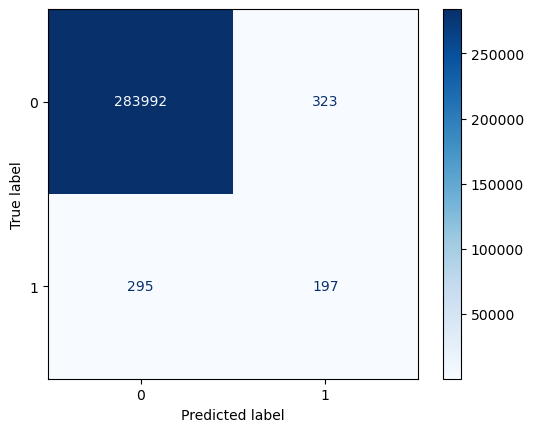

------------------------------------------------------------

    Отчет по рассчитанным метрикам качества классификации
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.38      0.40      0.39       492

    accuracy                           1.00    284807
   macro avg       0.69      0.70      0.69    284807
weighted avg       1.00      1.00      1.00    284807



In [17]:
show_model_metrics("IQR-based Outlier", data["Class"], outliers_by_features["IQR-based Outlier"])

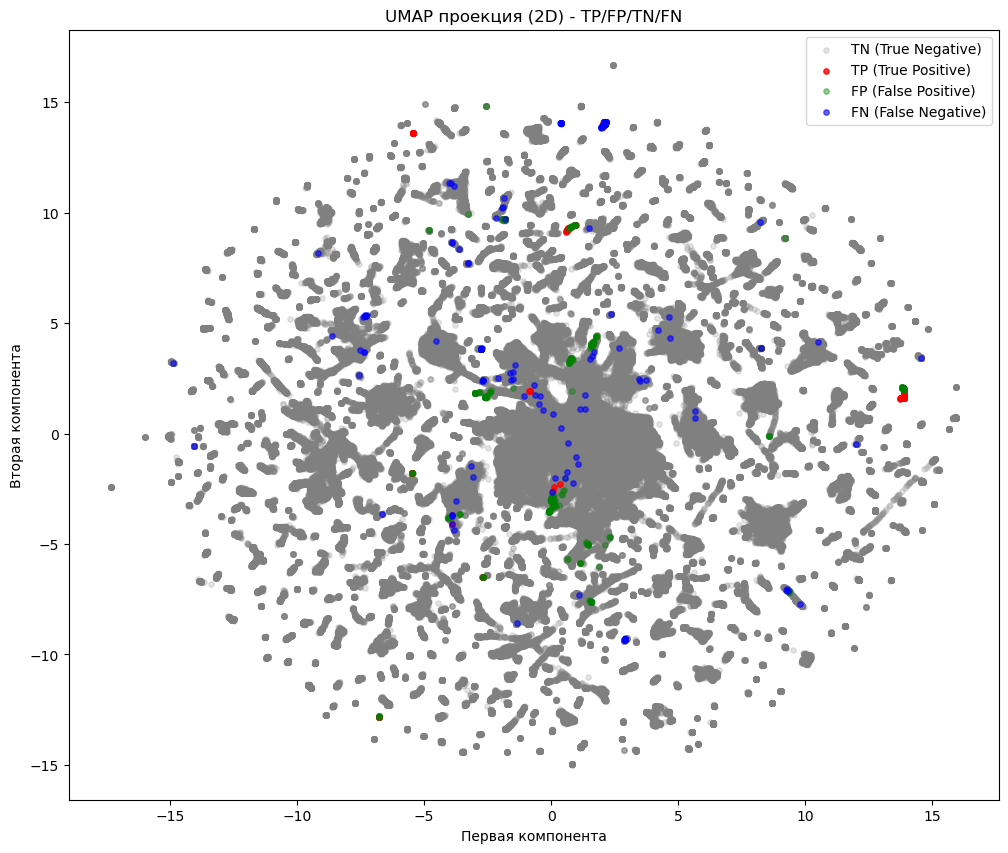

In [18]:
display_objects(data_reduced, data["Class"].values, outliers_by_features["IQR-based Outlier"].values)

<h3>OneClass SVM</h3>

<h4>Обучение модели</h4>

In [19]:
one_class_svm = OneClassSVM(nu=expert_assessment, gamma="auto", verbose=1)
one_class_svm.fit(data_scaled)
labels = one_class_svm.predict(data_scaled)

data["OneClassSVM pred"] = np.where(labels == -1, 1, 0)

print(f"Доля выбросов составляет {100 * data['OneClassSVM pred'].sum() / data.shape[0]:.3f}%")

[LibSVM]Доля выбросов составляет 0.889%


<h4>Оценка качества</h4>

                               Оценка качества модели OneClass SVM

                     Матрица ошибок


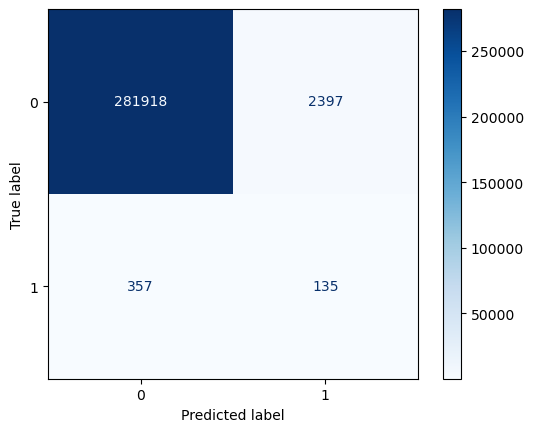

------------------------------------------------------------

    Отчет по рассчитанным метрикам качества классификации
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    284315
           1       0.05      0.27      0.09       492

    accuracy                           0.99    284807
   macro avg       0.53      0.63      0.54    284807
weighted avg       1.00      0.99      0.99    284807



In [20]:
show_model_metrics("OneClass SVM", data["Class"], data["OneClassSVM pred"])

<h4>Отображение аномалий на сжатом пространстве</h4>

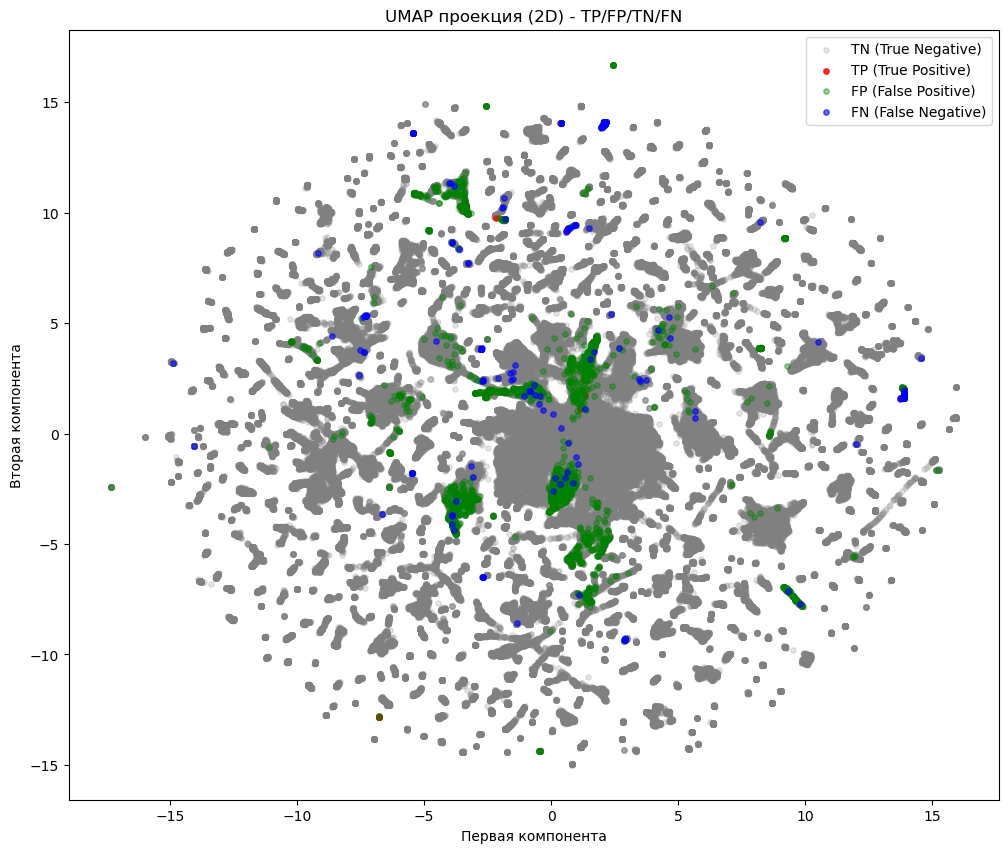

In [21]:
display_objects(data_reduced, data["Class"].values, data["OneClassSVM pred"].values)

<h3>IsolationForest</h3>

<h4>Обучение модели</h4>

In [22]:
iso = IsolationForest(n_estimators=500, max_samples=1000, max_features=data.shape[1] // 3, 
                      contamination=expert_assessment, bootstrap=True, n_jobs=-1)
iso.fit(data_scaled)
labels = iso.predict(data_scaled)

data["IsolationForest pred"] = np.where(labels == -1, 1, 0)

print(f"Доля выбросов составляет {100 * data['IsolationForest pred'].sum() / data.shape[0]:.3f}%")

Доля выбросов составляет 0.173%


<h4>Оценка качества</h4>

                               Оценка качества модели IsolationForest

                     Матрица ошибок


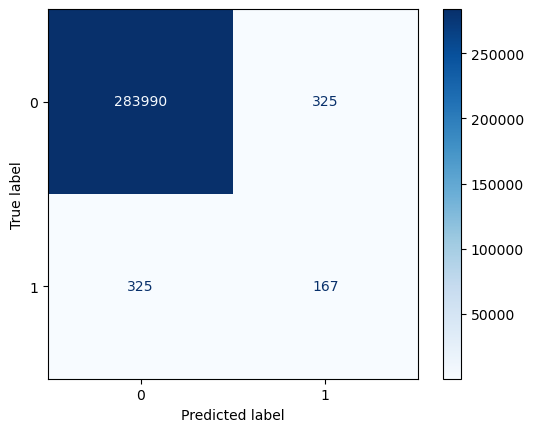

------------------------------------------------------------

    Отчет по рассчитанным метрикам качества классификации
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.34      0.34      0.34       492

    accuracy                           1.00    284807
   macro avg       0.67      0.67      0.67    284807
weighted avg       1.00      1.00      1.00    284807



In [23]:
show_model_metrics("IsolationForest", data["Class"], data["IsolationForest pred"])

<h4>Отображение аномалий на сжатом пространстве</h4>

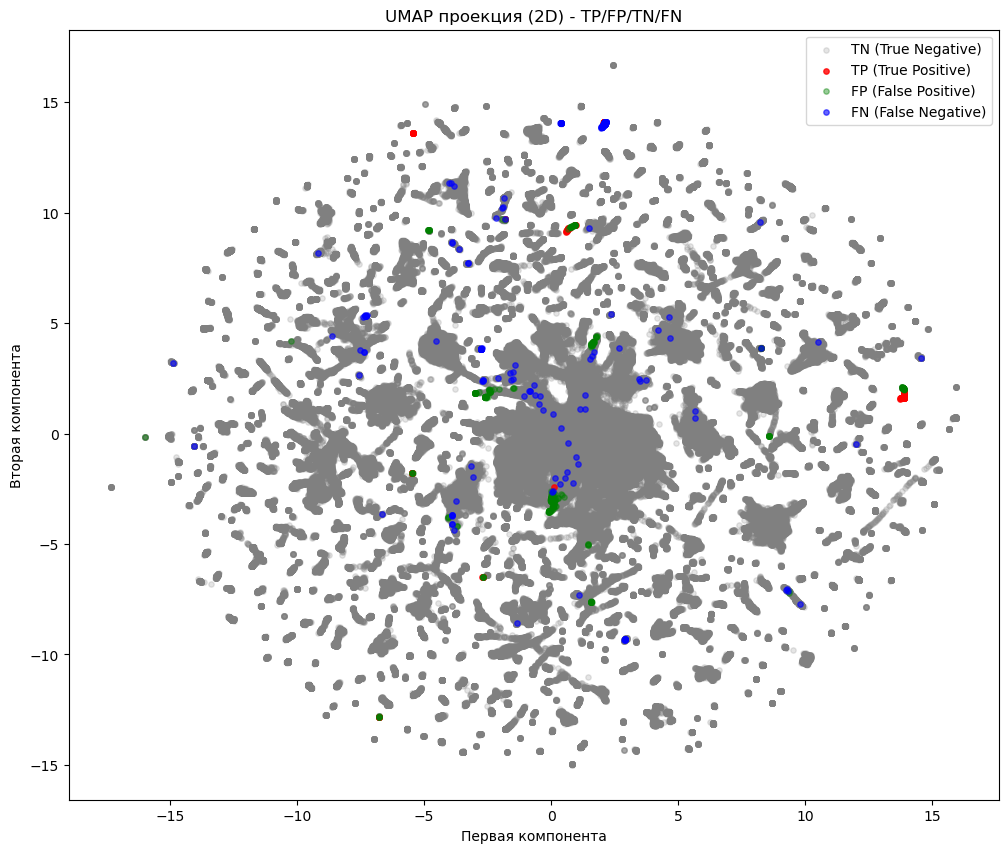

In [24]:
display_objects(data_reduced, data["Class"].values, data["IsolationForest pred"].values)

<h3>🔍Окончательный вывод по поиску аномалий</h3>

<p>В ходе эксперимента проводился поиск аномалий на компонентных представлениях данных. Использовались <b>IsolationForest, One-Class SVM</b> и метод частых отклонений в распределениях по каждому признаку.
</p>
<p>Основные результаты:</p>
<ul>
    <li>Согласно <b>экспертной оценке</b>, аномалий в данных <b>менее 1%</b>, что делает их обнаружение сложной задачей.</li>
    <li><b>Классические методы</b> (IsolationForest, SVM) показали ограниченную эффективность, находя лишь <b>≈35% аномалий</b> (recall), что может указывать на недостаточное разделение выбросов в компонентном пространстве.</li>
    <li>Метод частых отклонений показал аналогичные результаты, что подтверждает сложность выявления аномалий в данных.</li>
</ul>
<p>Методы поиска аномалий не дали точного результата из-за низкой доли аномалий (менее 1%) и слабого разделения выбросов в компонентах. Для улучшения качества детекции стоит попробовать <b>глубже анализировать компоненты, использовать нейронные сети или градиентный бустинг.</b></p>